<a href="https://colab.research.google.com/github/ytin16/ASTGCN-pytorch/blob/master/elasticNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 配置

In [96]:
! pip install -q kaggle

在 kaggle 主页点击自己的头像 - account，然后找到 API。然后按照上述说明书操作。

如果没有改动，所需上传的 kaggle.json 文件在“下载”文件夹中。

In [97]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"taoyin","key":"fa470cbd7380bb690d1aebf845cd7af2"}'}

In [98]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [99]:
! chmod 600 ~/.kaggle/kaggle.json

展示所有的可下载数据集
```
! kaggle datasets list
```

# 说明
这是对 TPS 9月的一个 notebook 的复现。

该模型使用 Ridge+Lasso+Linear+Elastic Ensemble

[original notebook](https://www.kaggle.com/code/juhjoo/4-41-tpg-sep-ridge-lasso-linear-elastic-ensemble/data)

# 下载所需数据

以下代码，去 competetion 的 data 页面最下方复制 API 即可。

注意改变 `-p` 的参数，选择合适的数据下载路径。

In [100]:
!kaggle competitions download -c tabular-playground-series-sep-2022 -p /content/data

tabular-playground-series-sep-2022.zip: Skipping, found more recently modified local copy (use --force to force download)


In [101]:
! mkdir train

mkdir: cannot create directory ‘train’: File exists


In [ ]:
! unzip /content/data/tabular-playground-series-sep-2022.zip -d train

下载公开 kernel 的数据。

首先找到他人的 notebook。

然后选择 data 选项，复制网页底端的 API。

最后，记得修改 `-p` 后的参数。

In [3]:
!kaggle datasets download -d hasanbasriakcay/tpssep22-gdp-data-20172021 -p /content/train

  0% 0.00/439 [00:00<?, ?B/s]
100% 439/439 [00:00<00:00, 289kB/s]


In [7]:
! unzip /content/train/tpssep22-gdp-data-20172021.zip -d train

Archive:  /content/train/tpssep22-gdp-data-20172021.zip
  inflating: train/TPSSEP22_GDP_data_2017_to_2021.csv  


# 准备工作

In [ ]:
#@title install package
!pip install optuna

In [6]:
#@title import package
import pandas as pd
import numpy as np
import os
import cv2
import gc
import re
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
from IPython import display as ipd
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
import random
from joblib import Parallel, delayed
import os, shutil
import datetime 
import holidays
import dateutil.easter as easter

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor
from sklearn.model_selection import StratifiedGroupKFold

from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
from xgboost import plot_importance

from xgboost import plot_importance
from matplotlib import pyplot
import missingno as msno
import plotly.express as px

import optuna

# Keras
import tensorflow as tf

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor

# Keras
from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from tensorflow.keras.layers import LSTM, Flatten, TimeDistributed, Conv1D, Input, Dense, Multiply, Add, Activation, GRU, BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model, save_model, Sequential
from tensorflow.data import Dataset
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten,MaxPooling1D,BatchNormalization, Lambda, AveragePooling1D, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow.keras as keras

# 读入数据

GDP数据：按年份，对所有国家 GDP 求和

In [8]:
df_gdp = pd.read_csv('/content/train/TPSSEP22_GDP_data_2017_to_2021.csv')
df_gdp_all = df_gdp.groupby('year')['GDP'].sum().reset_index()

In [ ]:
df_gdp.head()

In [ ]:
df_gdp_all.head()

In [11]:
train_df = pd.read_csv('/content/train/train.csv', parse_dates=['date'])
original_train_df = train_df.copy()
test_df = pd.read_csv('/content/train/test.csv', parse_dates=['date'])
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [12]:
for df in [train_df, test_df]:
    df['product'] = df['product'].str.replace(' ', '_')
    df['product'] = df['product'].str.replace(':', '_')

# EDA

In [13]:
train_df.isnull().sum()

row_id      0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [14]:
test_df.isnull().sum()

row_id     0
date       0
country    0
store      0
product    0
dtype: int64

In [15]:
print('\n  country in the train dataset\n')
print(train_df['country'].value_counts())

print('\n  country in the test dataset\n')
print(test_df['country'].value_counts())

print('\n store in the train dataset\n')
print(train_df['store'].value_counts())

print('\n store in the test dataset\n')
print(test_df['store'].value_counts())

print('\n product in the train dataset\n')
print(train_df['product'].value_counts())

print('\n product in the test dataset\n')
print(test_df['product'].value_counts())


  country in the train dataset

Belgium    11688
France     11688
Germany    11688
Italy      11688
Poland     11688
Spain      11688
Name: country, dtype: int64

  country in the test dataset

Belgium    2920
France     2920
Germany    2920
Italy      2920
Poland     2920
Spain      2920
Name: country, dtype: int64

 store in the train dataset

KaggleMart    35064
KaggleRama    35064
Name: store, dtype: int64

 store in the test dataset

KaggleMart    8760
KaggleRama    8760
Name: store, dtype: int64

 product in the train dataset

Kaggle_Advanced_Techniques          17532
Kaggle_Getting_Started              17532
Kaggle_Recipe_Book                  17532
Kaggle_for_Kids__One_Smart_Goose    17532
Name: product, dtype: int64

 product in the test dataset

Kaggle_Advanced_Techniques          4380
Kaggle_Getting_Started              4380
Kaggle_Recipe_Book                  4380
Kaggle_for_Kids__One_Smart_Goose    4380
Name: product, dtype: int64


In [16]:
print("train min date:", train_df['date'].min())
print("train max date:", train_df['date'].max())
print("test min date:", test_df['date'].min())
print("test max date:", test_df['date'].max())

train min date: 2017-01-01 00:00:00
train max date: 2020-12-31 00:00:00
test min date: 2021-01-01 00:00:00
test max date: 2021-12-31 00:00:00


<Figure size 1080x432 with 0 Axes>

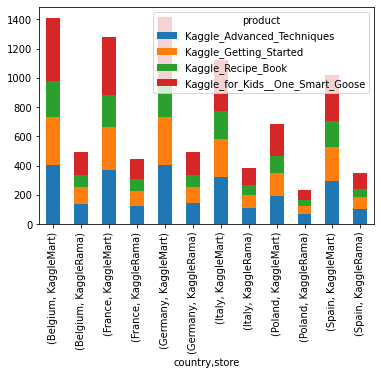

In [17]:
#@markdown 使用 stacked bar plot 展示 3 个类别维度下的数据

#@markdown 不同国家、商店、产品种类的总销量
plt.figure(figsize=(15,6))
train_df.groupby(['country','store','product'])['num_sold'].mean().unstack().plot(kind='bar',stacked=True)
plt.show()

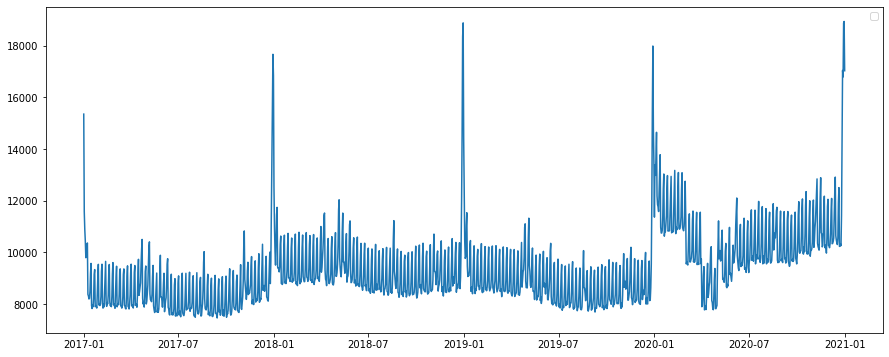

In [18]:
# @markdown 每日总销量
plt.figure(figsize=(15,6))
train_gp = train_df.groupby('date').sum().reset_index()
plt.plot(train_gp['date'], train_gp['num_sold'])
plt.legend()
plt.show()

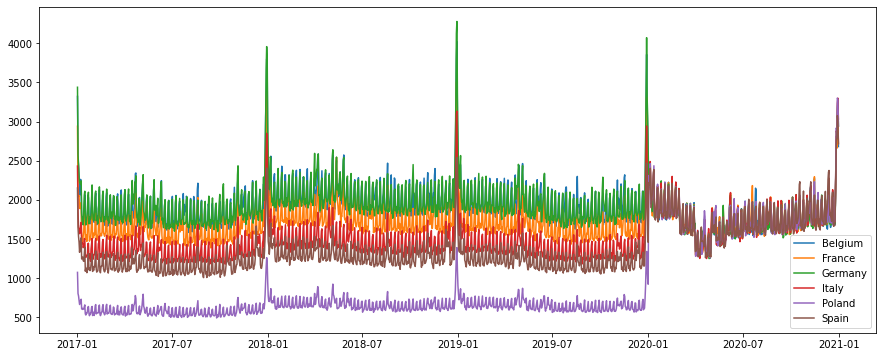

In [19]:
#@markdown 不同国家每天销量
plt.figure(figsize=(15,6))
for country in train_df['country'].unique():
    filt_train = train_df[train_df['country'] == country]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=country)
plt.legend()
plt.show()

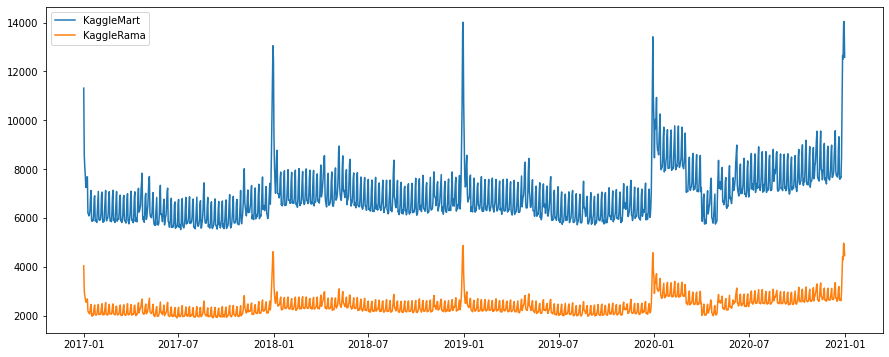

In [20]:
#@markdown 不同商店每天销量
plt.figure(figsize=(15,6))
for store in train_df['store'].unique():
    filt_train = train_df[train_df['store'] == store]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=store)
plt.legend()
plt.show()

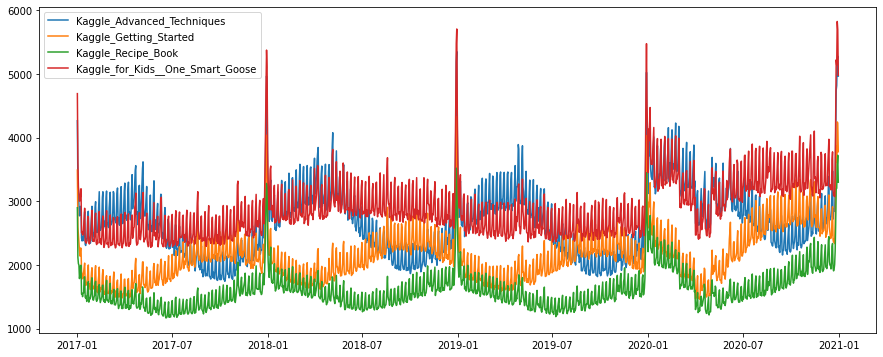

In [21]:
#@markdown 不同产品每天销量
plt.figure(figsize=(15,6))
for product in train_df['product'].unique():
    filt_train = train_df[train_df['product'] == product]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=product)
plt.legend()
plt.show()

In [22]:
#@markdown 计算周均、月均数据
weekly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

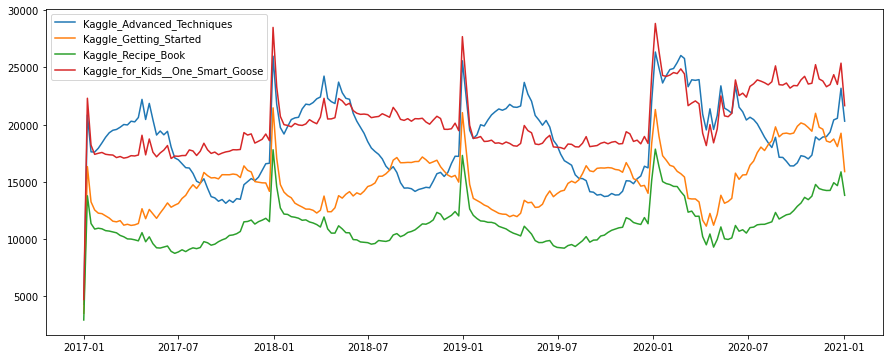

In [23]:
#@markdown 周均销售数据
plt.figure(figsize=(15,6))
for product in train_df['product'].unique():
    filt_train = weekly_df[weekly_df['product'] == product]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=product)
plt.legend()
plt.show()

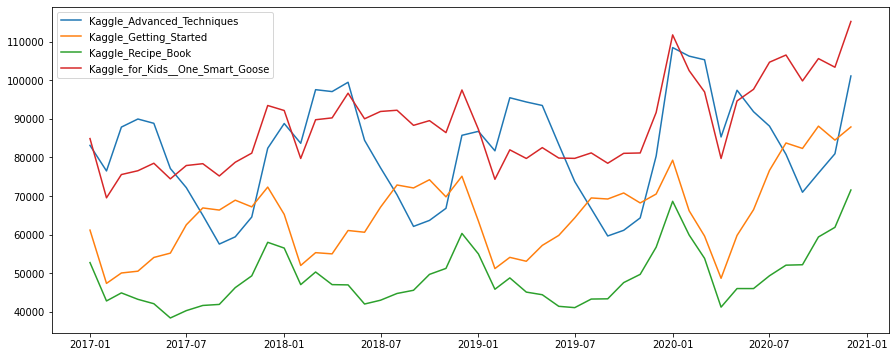

In [24]:
#@markdown 月均销售数据
plt.figure(figsize=(15,6))
for product in train_df['product'].unique():
    filt_train = monthly_df[monthly_df['product'] == product]

    train_gp = filt_train.groupby('date').sum().reset_index()
    plt.plot(train_gp['date'], train_gp['num_sold'], label=product)
plt.legend()
plt.show()

In [25]:
product_store_weights = monthly_df.groupby(["product","store"])["num_sold"].sum() / monthly_df.groupby(["product"])["num_sold"].sum()
product_store_weights

product                           store     
Kaggle_Advanced_Techniques        KaggleMart    0.742447
                                  KaggleRama    0.257553
Kaggle_Getting_Started            KaggleMart    0.742500
                                  KaggleRama    0.257500
Kaggle_Recipe_Book                KaggleMart    0.742765
                                  KaggleRama    0.257235
Kaggle_for_Kids__One_Smart_Goose  KaggleMart    0.742450
                                  KaggleRama    0.257550
Name: num_sold, dtype: float64

In [26]:
store_weights = train_df.groupby("store")["num_sold"].sum()/train_df["num_sold"].sum()
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

In [27]:
new_monthly_df = monthly_df.loc[monthly_df["date"] < "2020-01-01"]
product_country_weights = new_monthly_df.groupby(["product","country"])["num_sold"].sum() / new_monthly_df.groupby(["product"])["num_sold"].sum()
product_country_weights

product                           country
Kaggle_Advanced_Techniques        Belgium    0.218832
                                  France     0.191456
                                  Germany    0.219423
                                  Italy      0.159464
                                  Poland     0.071352
                                  Spain      0.139474
Kaggle_Getting_Started            Belgium    0.219094
                                  France     0.191188
                                  Germany    0.219410
                                  Italy      0.159473
                                  Poland     0.071316
                                  Spain      0.139518
Kaggle_Recipe_Book                Belgium    0.219069
                                  France     0.191101
                                  Germany    0.219778
                                  Italy      0.159175
                                  Poland     0.071355
                                  Spain 

In [28]:
(product_country_weights.reset_index().groupby("country")["num_sold"].mean().loc["Belgium"] / product_country_weights.reset_index().groupby("country")["num_sold"].mean())

country
Belgium    1.000000
France     1.144428
Germany    0.997088
Italy      1.373899
Poland     3.068876
Spain      1.570512
Name: num_sold, dtype: float64

In [30]:
product_df = train_df.groupby(["date","product"])["num_sold"].sum().reset_index()
product_df.head()

,date,product,num_sold
0,2017-01-01,Kaggle_Advanced_Techniques,4267
1,2017-01-01,Kaggle_Getting_Started,3492
2,2017-01-01,Kaggle_Recipe_Book,2900
3,2017-01-01,Kaggle_for_Kids__One_Smart_Goose,4693
4,2017-01-02,Kaggle_Advanced_Techniques,3242


In [32]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df.head(4)

,date,product,ratios
0,2017-01-01,Kaggle_Advanced_Techniques,0.277944
1,2017-01-01,Kaggle_Getting_Started,0.227462
2,2017-01-01,Kaggle_Recipe_Book,0.188900
3,2017-01-01,Kaggle_for_Kids__One_Smart_Goose,0.305693


In [33]:
product_ratio_df.tail()

,date,product,ratios
5839,2020-12-30,Kaggle_for_Kids__One_Smart_Goose,0.300929
5840,2020-12-31,Kaggle_Advanced_Techniques,0.291703
5841,2020-12-31,Kaggle_Getting_Started,0.221948
5842,2020-12-31,Kaggle_Recipe_Book,0.193823
5843,2020-12-31,Kaggle_for_Kids__One_Smart_Goose,0.292525


另一位大佬说过：看似我们需要预测 48 条时间序列。实际上，我们只需要预测 1 条时间序列，然后将它按比例分配给不同的产品，再分配给不同的国家、地区。

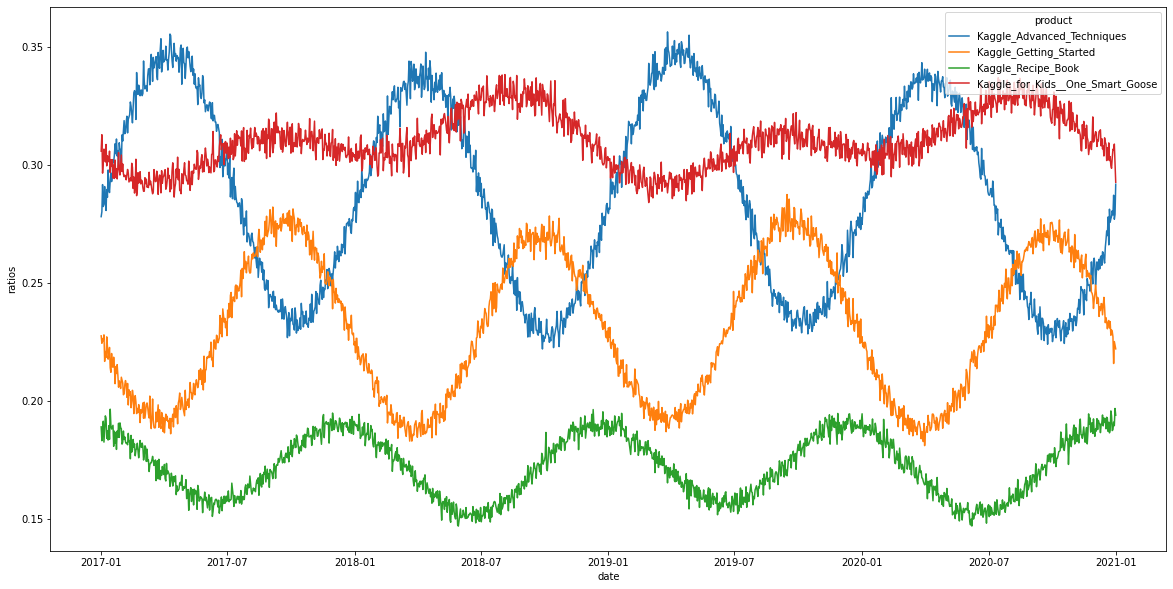

In [34]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="ratios", hue="product");

# FE

In [35]:
train_df = train_df.groupby(["date"])["num_sold"].sum().reset_index()

In [36]:
weekly_df = train_df.groupby([pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby([pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

将2020年3月~6月视为 covid 影响下的异常数据

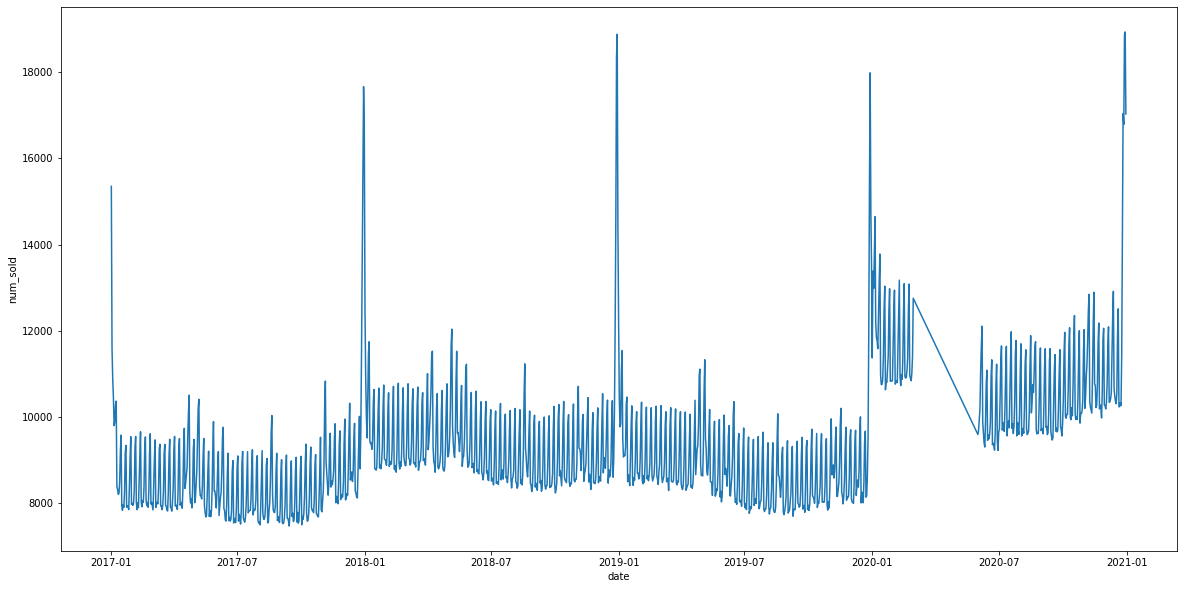

In [37]:
train_nocovid_df = train_df.loc[~((train_df["date"] >= "2020-03-01") & (train_df["date"] < "2020-06-01"))]
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_nocovid_df, x="date", y="num_sold");

In [38]:
train_df = train_nocovid_df

#get the dates to forecast for
test_all_df = test_df.groupby(["date"])["row_id"].first().reset_index().drop(columns="row_id")
#keep dates for later
test_all_df_dates = test_all_df[["date"]]

https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/discussion/278588

In [61]:
for col in piggydf.columns :
        if 'easter' in col :
            piggydf = pd.get_dummies(piggydf, columns = [col], drop_first=True)

In [66]:
def feature_engineer(df):
    new_df = df.copy()

    # 月份和基于它的周期项
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    # 日期，即每月的几号，取值范围 1~31。
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
    #new_df["day_cos"] = np.cos(new_df['day'] * (2 * np.pi / 12))
    
    # 星期几？周一 ~ 周四设置为0，周五、周六、周日分别设置为 1、2、3
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    # 布尔特征，是否是周五、周六、周日？还生成周五+周日、周六+周日的线性组合。
    new_df['friday'] = new_df.date.dt.weekday.eq(4).astype(np.uint8)
    new_df['saturday'] = new_df.date.dt.weekday.eq(5).astype(np.uint8)
    new_df['sunday'] = new_df.date.dt.weekday.eq(6).astype(np.uint8)
    new_df['sat+sun'] = new_df['saturday']+new_df['sunday']
    new_df['fri+sun'] = new_df['friday']+new_df['sunday']
    
    # 每年的第几天，取值范围 1~365，区别于日期。
    new_df["day_of_year"] = df["date"].dt.dayofyear

    # 2020年是闰年，闰日后的每一天都减一，消除闰日的影响
    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    
    # 每年中重要的日子，为什么这些日子重要？可能是试出来的。不重要的日子取值为0.
    important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,16,17,22,23,24,105, 123,124, 125, 126, 127, 140, 141,142, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179,
                  180, 181, 203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]
    

    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in important_dates else 0)
    #new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    
    new_df["year"] = df["date"].dt.year
    #new_df['is_pandemic_year'] = new_df['year'].astype(int) >= 2020
    '''
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"easter{d}": 
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(51, 58))})],
                       axis=1)
    '''
    
    # 复活节相关。PS：复活前前后5天是节日，复活节后40天的一周内也是节日。
    # 这里创造了 17 个布尔特征。例如 easter_-5 代表今天是不是复活节之前的第5天。
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    for day in list(range(-5, 5)) + list(range(40, 48)):
        new_df[f'easter_{day}'] = (new_df.date - easter_date).dt.days.eq(day)

    # 把布尔特征的 true false 变成 {0,1}   
    for col in new_df.columns :
        if 'easter' in col :
            new_df = pd.get_dummies(new_df, columns = [col], drop_first=True)

    # 为圣诞节假期创造 7 个布尔变量        
    for day in range(24, 32):
        new_df[f'Dec_{day}'] = new_df.date.dt.day.eq(day) & new_df.date.dt.month.eq(12)
        
    # 删去原始日期、每月几号、月份、每年的第几天
    new_df = new_df.drop(columns=["date","month","day", "day_of_year"])
    
    # 将类别变量 encode 成为多个 0-1 变量
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

In [70]:
years_list = [2017, 2018, 2019, 2020, 2021]

holiday_BE = holidays.CountryHoliday('BE', years = years_list)
holiday_FR = holidays.CountryHoliday('FR', years = years_list)
holiday_DE = holidays.CountryHoliday('DE', years = years_list)
holiday_IT = holidays.CountryHoliday('IT', years = years_list)
holiday_PL = holidays.CountryHoliday('PL', years = years_list)
holiday_ES = holidays.CountryHoliday('ES', years = years_list)

holiday_dict = holiday_BE.copy()
holiday_dict.update(holiday_FR)
holiday_dict.update(holiday_DE)
holiday_dict.update(holiday_IT)
holiday_dict.update(holiday_PL)
holiday_dict.update(holiday_ES)

In [67]:

def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021]

    holiday_BE = holidays.CountryHoliday('BE', years = years_list)
    holiday_FR = holidays.CountryHoliday('FR', years = years_list)
    holiday_DE = holidays.CountryHoliday('DE', years = years_list)
    holiday_IT = holidays.CountryHoliday('IT', years = years_list)
    holiday_PL = holidays.CountryHoliday('PL', years = years_list)
    holiday_ES = holidays.CountryHoliday('ES', years = years_list)

    holiday_dict = holiday_BE.copy()
    holiday_dict.update(holiday_FR)
    holiday_dict.update(holiday_DE)
    holiday_dict.update(holiday_IT)
    holiday_dict.update(holiday_PL)
    holiday_dict.update(holiday_ES)

    # holiday_name 是文字型特征，在相应的日期标注节日，不是节日标注"not holiday"
    # is_holiday 布尔特征，是否是节日
    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df

In [78]:

def encode_holiday_names(df, enc, subset='train'):
    if subset=='train':
        df['holiday_name'] = enc.fit_transform(df['holiday_name'].values.reshape(-1,1))
    else: 
      # 条件块从未被处罚，不知道这段代码的意义。
        df['holiday_name'] = enc.transform(df['holiday_name'].values.reshape(-1,1))
        not_hol_val = enc.transform([['Not Holiday']])[0,0]
        df.loc[df['holiday_name']==-1, 'holiday_name'] = not_hol_val
    return df

OrdinalEncoder 将类别变量编码为 0\~N-1 

下述代码中`handle_unknown='use_encoded_value', unknown_value=-1` 意思是：如果在 `transform` 时遇到了 `fit` 包含的类别之外的类别，就标记为 -1

In [75]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [76]:
train_all_df = get_holidays(train_df)
test_all_df = get_holidays(test_all_df)

In [77]:
train_all_df = feature_engineer(train_all_df)
test_all_df = feature_engineer(test_all_df)

In [79]:
train_all_df = encode_holiday_names(train_all_df, oe)
test_all_df = encode_holiday_names(test_all_df, oe)

尝试加入 GDP 数据、考虑 Covid，但又放弃了
```python
# Add GDP Feature
train_all_df = train_all_df.merge(df_gdp_all, left_on=['year'], right_on=['year'], how='left')
test_all_df = test_all_df.merge(df_gdp_all, left_on=['year'], right_on=['year'], how='left')

train_all_df.loc[train_all_df[(train_all_df['is_pandemic_year'] == False)]['is_pandemic_year'].index, 'is_pandemic_year'] = 0
train_all_df.loc[train_all_df[(train_all_df['is_pandemic_year'] == True)]['is_pandemic_year'].index, 'is_pandemic_year'] = 1
test_all_df.loc[test_all_df[(test_all_df['is_pandemic_year'] == True)]['is_pandemic_year'].index, 'is_pandemic_year'] = 1
test_all_df.loc[test_all_df[(test_all_df['is_pandemic_year'] == True)]['is_pandemic_year'].index, 'is_pandemic_year'] = 1
train_all_df['is_pandemic_year'] = train_all_df['is_pandemic_year'].astype('uint')
test_all_df['is_pandemic_year'] = test_all_df['is_pandemic_year'].astype('uint')
```


In [87]:
display(train_all_df.head(2))
display(test_all_df.head(2))

,num_sold,holiday_name,is_holiday,month_sin,month_cos,day_sin,friday,saturday,sunday,sat+sun,...,important_dates_320,important_dates_360,important_dates_361,important_dates_362,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3
0,15352,26.0,1,0.5,0.866025,0.500000,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
1,11578,3.0,1,0.5,0.866025,0.866025,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,holiday_name,is_holiday,month_sin,month_cos,day_sin,friday,saturday,sunday,sat+sun,fri+sun,...,important_dates_320,important_dates_360,important_dates_361,important_dates_362,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3
0,2.0,1,0.5,0.866025,0.500000,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,19.0,0,0.5,0.866025,0.866025,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


# 训练模型

In [88]:
y = train_all_df["num_sold"]
X = train_all_df.drop(columns="num_sold")
X_test = test_all_df

使用的 error 较为罕见：Symmetric Mean Absolute Percentage Error。是 MAPE 的变种

*发散：不能叫做“Mean”，这里并没有求“均值” —— 当然，也可以说输出是一维的，一维不需要再平均。*

$$
\begin{align}
\text{MAPE}=\frac{1}{n}|\frac{\hat{y}_i-y_i}{y_i}|\\
\text{SMAPE}=\frac{1}{n}|\frac{\hat{y}_i-y_i}{(y_i+\hat{y}_i)/2}|
\end{align}
$$

In [89]:
def smape(y_true, y_pred):
    smape = abs(y_true - y_pred) / (abs(y_true) + abs(y_pred))
    smape = smape.mean() * 200
    return smape

In [90]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

训练 4 种模型：
* 线性回归
* ridge
* Lasso
* elastic net

**首先，使用默认参数建立 baseline**

In [91]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
linear_preds = linear_model.predict(x_test)

ridge_model = Ridge(tol=1e-2, max_iter=1000000, random_state=42)
ridge_model.fit(x_train, y_train)
ridge_preds = ridge_model.predict(x_test)

lasso_model = Lasso(tol=1e-2, max_iter=1000000, random_state=42)
lasso_model.fit(x_train, y_train)
lasso_preds = lasso_model.predict(x_test)

electic_model = ElasticNet(alpha=0.01, l1_ratio=0.01, random_state=42)
electic_model.fit(x_train, y_train)
electic_preds = electic_model.predict(x_test)

print('lr_pre : ',smape(y_test,linear_preds))
print('ridge_pre : ',smape(y_test,ridge_preds))
print('lasso_pre : ',smape(y_test,lasso_preds))
print('electic_pre : ',smape(y_test,electic_preds))

lr_pre :  6.874116746225048
ridge_pre :  5.576696765774138
lasso_pre :  5.494429635156214
electic_pre :  5.9227266998681


使用 `GridSearchCV` 搜索优化超参数

```
ridge_params = {'alpha' :  0.0001 * np.arange(1, 1000)}
grid = GridSearchCV(estimator = ridge_model, param_grid = ridge_params, scoring = 'neg_mean_absolute_error')

grid.fit(X, y)
best_param = grid.best_params_
print(best_param)
```

In [93]:
ridge_model2 = Ridge(alpha=0.0999, tol=1e-2, max_iter=1000000, random_state=42)
ridge_model2.fit(x_train, y_train)
ridge_preds2 = ridge_model2.predict(x_test)
print('ridge_pre2 : ',smape(y_test,ridge_preds2))

ridge_pre2 :  5.575966478371272


```
lasso_params = {'alpha' :  0.0001 * np.arange(1, 1000) }
grid = GridSearchCV(estimator = lasso_model, param_grid = lasso_params, scoring = 'neg_mean_absolute_error')

grid.fit(X, y)
best_param = grid.best_params_
print(best_param)
```

比较搞笑的是，网格搜索找出来的 lasso 比使用默认参数的 lasso 在测试集上表现差一些

In [94]:
lasso_model2 = Lasso(alpha=0.0099, tol=1e-2, max_iter=1000000, random_state=42)
lasso_model2.fit(x_train, y_train)
lasso_preds2 = lasso_model2.predict(x_test)
print('ridge_pre2 : ',smape(y_test,lasso_preds2))

ridge_pre2 :  5.589725107769571


```
electic_param = {
     'alpha': 0.0001 * np.arange(1, 100),
     'l1_ratio': 0.001 * np.arange(1, 10)}

grid = GridSearchCV(estimator = electic_model, param_grid = electic_param, scoring = 'neg_mean_absolute_error')
    
grid.fit(X, y)
best_param = grid.best_params_
print(best_param)
```

In [95]:
elastic_model2 = ElasticNet(alpha=0.0002, l1_ratio=0.001, random_state=42)
elastic_model2.fit(x_train, y_train)
elastic_preds2 = elastic_model2.predict(x_test)
print('elastic_pre2 : ',smape(y_test,elastic_preds2))

elastic_pre2 :  5.565948686173302


使用找到最优参数，用所有的数据做 KFold，找到多个模型。

此处使用 `GroupKFold`
```python
kf = GroupKFold(n_splits=4)
kf.split(X, groups=X.year)
```

效果是，每次都使用一整年的数据作为验证集。

不同类别 KFold 详细解释见[链接](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)

In [96]:
elastic_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for trn_idx, test_idx in kf.split(X, groups=X.year) :
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[test_idx]
    
    elastic_model = ElasticNet(alpha=0.0002, l1_ratio=0.001, random_state=42)
    #elastic_model = make_pipeline(StandardScaler(), elastic_model)
    elastic_model.fit(x_train, y_train)

    y_pred = elastic_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)

    n = n + 1

    test_pred = elastic_model.predict(X_test)
    pred = pd.Series(test_pred) 

    elastic_preds += pred / kf.n_splits  
    
print(f"smape: {avg_smape/kf.n_splits}")

smape: 9.843818067170218


In [97]:
ridge_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for trn_idx, test_idx in kf.split(X, groups=X.year) :
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[test_idx]
    
    ridge_model = Ridge(alpha=0.0999, tol=1e-2, max_iter=1000000, random_state=0)
    #ridge_model = make_pipeline(StandardScaler(), ridge_model)
    ridge_model.fit(x_train, y_train)

    y_pred = ridge_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)

    n = n + 1

    test_pred = ridge_model.predict(X_test)
    pred = pd.Series(test_pred) 

    ridge_preds += pred / kf.n_splits  
    
print(f"smape: {avg_smape/kf.n_splits}")

smape: 9.856854422717761


In [98]:
lasso_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for trn_idx, test_idx in kf.split(X, groups=X.year) :
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[test_idx]
    
    lasso_model = Lasso(alpha=0.0999, tol=1e-2, max_iter=1000000, random_state=0)
    #lasso_model = make_pipeline(StandardScaler(), lasso_model)
    lasso_model.fit(x_train, y_train)

    y_pred = lasso_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)

    n = n + 1

    test_pred = lasso_model.predict(X_test)
    pred = pd.Series(test_pred) 

    lasso_preds += pred / kf.n_splits  
    
print(f"smape: {avg_smape/kf.n_splits}")

smape: 9.856958277436139
